# Problem Set 6: Neural Networks


<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

<span style="color:red">Note:</span> If you are using Google Colab for this problem set, make sure to turn off the Gemini assistant. 

<span style="color:red">Note:</span> Lab 9 is your friend -- many of the examples will help you answers in this problem set. 

# Truck v/s Cars: Neural Networks and Image Classification

Your goal for this problem set is to train neural network models for image classification. Specifically, your task is to train models that correctly predict where the vehicle in a given image is a truck, or a car / automobile.

It might be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

From a coding perspective, it will be easiest to complete all the problems using pytorch; however, if you prefer to use keras / tensorflow or any other deeplearning API, feel free to do so. 

--- 
# Part 0

### Question 1 - upload your ipynb to bcourses

### Question 2 - upload your pdf to bcourses


### Question 3 - please provide a summary of any resources consulted, and people with whom you worked in the completion of the problem set.

Highlight any specific LLM prompts/resources used at the point of use.

# Part I. 

## Question 4: Load Data +  Exploratory Analysis

For this problem, we'll load the [CIFAR 10](https://en.wikipedia.org/wiki/CIFAR-10) dataset
. This dataset has been widely used in ML and computer vision research -- you can read more about the state of the art model performance (and how this has improved over time) [here](https://en.wikipedia.org/wiki/CIFAR-10).

The CIFAR 10 dataset originally has 10 classes -- we've provided helper code below to load the data, and remove images belonging to unnecessary classes. We will use this dataset for a supervised binary classification problem.

Your tasks:
- Create a subset of the CIFAR 10 data, keeping only the car (automobile) and truck classes.  
- Select 9 random images from your training set. Plot these images in a 3 X 3 grid, along with the corresponding category / label
- Plot the distribution of labels in your training, validation and test sets. 


In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tensorboard import summary
import torcheval

In [33]:

def load_cifar10(data_path):
    """
    Helper code to clean the CIFAR 10 dataset, and remove the unnecessary classes. 
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']    """

    
    cifar10 = datasets.CIFAR10(
        data_path, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(), 
            # transforms.Normalize((0.4915, 0.4823, 0.4468),
            #                      (0.2470, 0.2435, 0.2616))
        ]))

    cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.4915, 0.4823, 0.4468),
        #                      (0.2470, 0.2435, 0.2616))
    ]))

    return cifar10, cifar10_val

In [34]:
## Load CIFAR data
datapath = '../data-unversioned/p1ch6/'
cifar10, cifar10_val = load_cifar10(datapath)

In [35]:
# Create training subset with only car and truck labels
sel_labels = [1,9]
targets = np.array(cifar10.targets)
idxs = np.where(np.isin(targets, sel_labels))[0]
cifar10_sub = torch.utils.data.Subset(cifar10, idxs)

#Split training subset into training and validation
total_len =len(cifar10_sub)
val_len = int(0.2 * total_len)
train_len = total_len - val_len
cifar10_sub_tr, cifar10_sub_tr_val = torch.utils.data.random_split(
    cifar10_sub, [train_len, val_len],
    generator = torch.Generator().manual_seed(31))


# Create subset with only car and truck labels for test set
targets = np.array(cifar10_val.targets)
idxs = np.where(np.isin(targets, sel_labels))[0]
cifar10_val_sub = torch.utils.data.Subset(cifar10_val, idxs)

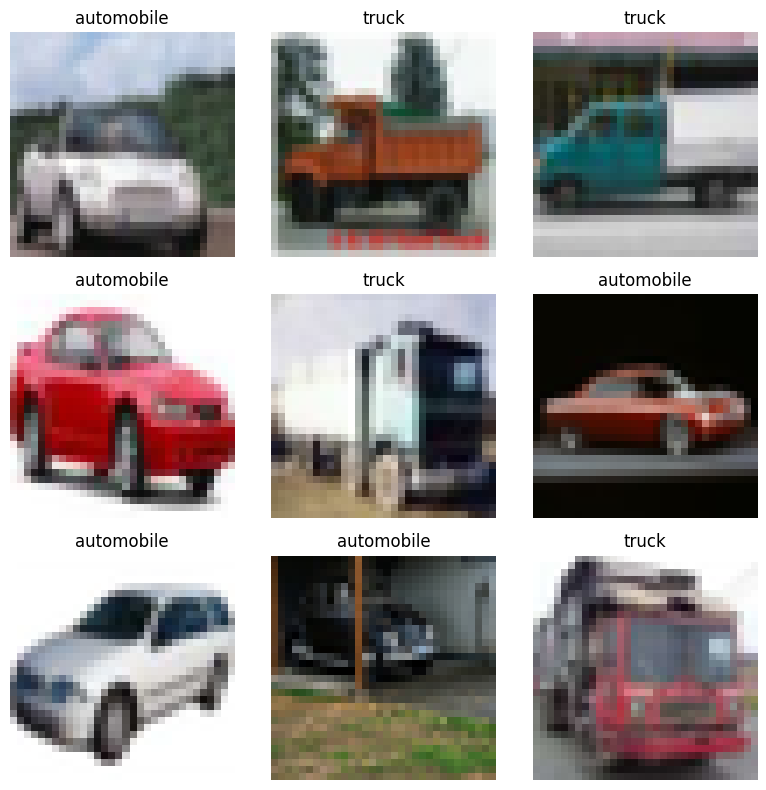

In [ ]:
#Display 9 random images with labels
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

rdm_idx = torch.randperm(len(cifar10_sub_tr))[:9]

fig, axes = plt.subplots(3,3, figsize =(8,8))

for ax, idx in zip(axes.flat, rdm_idx):
    image_tensor, label_idx = cifar10_sub_tr[idx]
    img_np = image_tensor.permute(1,2,0).numpy()
    ax.imshow(img_np)
    ax.set_title(class_names[label_idx])
    ax.axis('off')
     
plt.tight_layout()
plt.show()

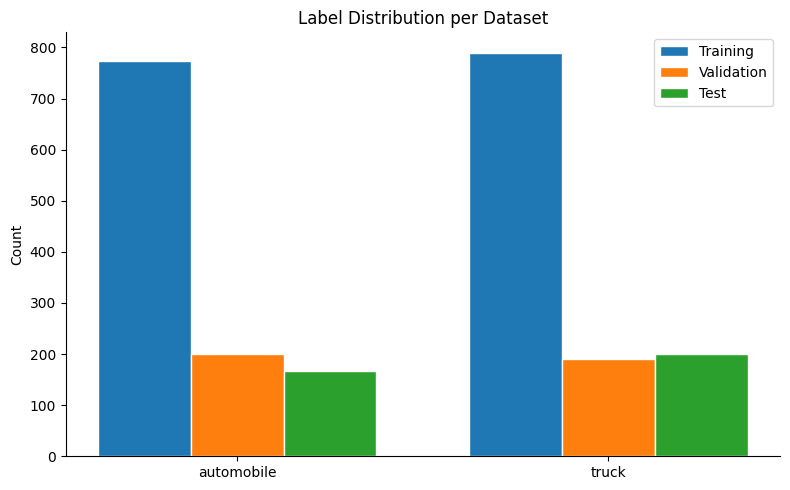

In [ ]:
targets = np.array(cifar10.targets)

datasets = [cifar10_sub_tr,cifar10_sub_tr_val,cifar10_val_sub]
labels = ['Training', 'Validation', 'Test']
classes = [1, 9]

counts = []
for subset in datasets:
    data = targets[subset.indices]
    counts.append(np.bincount(data, minlength = 10)[classes])

counts = np.array(counts).T #Final shape of counts (2 rows - classes, 3 columns - datasets)

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize =(8,5))
for i, label in enumerate(labels):
    ax.bar(x + i * width, counts[:, i], width=width, label=label, edgecolor = 'white', linewidth = 1)

ax.set_xticks(x + width)
ax.set_xticklabels(['automobile', 'truck'])
ax.set_ylabel("Count")
ax.set_title("Label Distribution per Dataset")
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

# Question 5: Convolutional Filters

Let's build some intuition for what convolutions actually do. First, complete the following steps. Then, answer the questions below. 

1. initizialize a convolutional layer (using nn.Conv2d):
    - in_channels: 3
    - out_channels: 1
    - kernel_size: 3
    - padding: 1

2. assign the following weights to the convolutional layer

\begin{align*}
\begin{bmatrix}
    -1.0 & -1.0 & -1.0\\
    0.0 & 0.0 & 0.0 \\
    1.0 & 1.0 & 1.0\\
\end{bmatrix}
\end{align*}

3. Pass the first image from the training dataset through this convolutional layer

4. Plot the raw image, and the resulting output

Then, answer the following questions

1. What do you notice about the output image? After applying the convolutional filter, what kind of features are more prominent / enhanced? Why is this the case (or in other words, what does step 2 help us achieve?)?
2. Here, we are explicitly assigning weights to this convolutional filter. This is never really done in practice; the goal is for the network estimate different filters from data in whatever way the discrimination is most effective. However, this does bring up some questions about different kinds of weight initializations and their consequences:
    - suppose we initialize convolutional layers with all the weights to zero. what would be the consequence?
    - instead, suppose we initialize the weights with random numbers (as is commonly done) -- what are some of the drawbacks of this approach?
    
Hint 1: Review the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)\
Hint 2: Use conv.weight[:] to set the weights, where "conv" is the name of your convolutional layer.

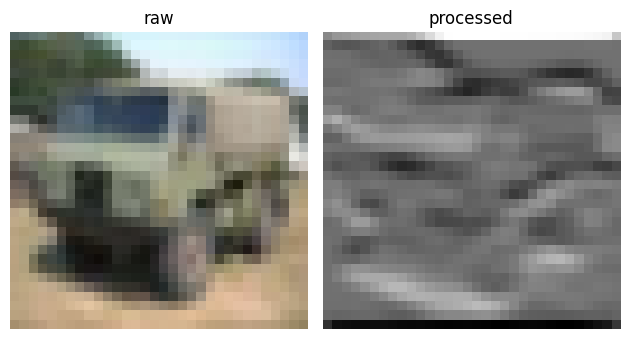

In [38]:
#Initialise single convolutional layer
tr_nn = nn.Conv2d(in_channels= 3,out_channels= 1,kernel_size= 3,padding= 1)


with torch.no_grad(): #Prevent pytorch from tracking operation
    #Initialise kernel weights
    kernel = torch.tensor([ 
    [ -1.0, -1.0, -1.0],
    [0.0, 0.0, 0.0],
    [1.0,  1.0,  1.0]
    ])

    #Apply weights to each input channel
    for i in range(3):
        tr_nn.weight[0,i] = kernel

image, label_idx = cifar10_sub_tr[0]
img_np = image.clone().permute(1,2,0).numpy()
image = image.unsqueeze(0) # Add additional dimension to match tr_nn input size
output = tr_nn(image) # Pass image thorugh layer

# Remove batch and channel dimensions
output_img = output.squeeze().detach().numpy()

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_np)
ax[0].set_title('raw')

ax[1].imshow(output_img,cmap = 'gray')
ax[1].set_title('processed')

ax[0].axis('off')
ax[1].axis('off')

plt.tight_layout()
plt.show()

1. After the appication of the filter, the output image emphasises the edges of the object or any portion of the image where there is a significant cahnge in colour. This is because the filter selected is similar to the Sobel filter, highlighting regions where there is a drastic change in pixel intensities. This is useful as it helps highlight the object boundaries, which will allow downstream layers to recognize the shape and structure more effectively.

2. If we initialise the weights to zero, the filter would always result in a zero output regardless of the input. During backpropogation, this would lead to identical gradients for all the weights - and they would remain unchanged after the updates. The network would thus not be abel to learn any features and training will stall. Random initialisation of weights prevents the problem of zero weights, ensuring that different neurons are able to learn different features of the image. However, when the selected values are too small, we get the issue of vanishing gradient, where during back propogation the calculated gradient using the weights shrinks with each layer and vanishes. This results in the weights of lower levels not being updated, and learning does not occur. On the other hand, when the selected values are too large, we get the issue of exploding gradients, where the calculated gradient becomes too large, making the network unstable. Finally, if the selected random values are too far from the true value, a large number of epochs are required for convergence, making the network inefficient. 

# II. Neural Networks

# Question 6: Helper Functions

Complete the following functions:
- training: which invokes the training loop, similar to what we saw in Lab 9. 
- validate: given a trained model and data loader, generate performance metrics

Here is an example of how you will use these functions:

test_loader = ... (Define your data loader)

learning_rate = .. (define learning rate)\
neural_network = .. (initialize your neural network)\
optimizer = .. (set up your optimizer)\
loss_fn = .. (set up your loss function)

training( ....) 

validate(...)

In [ ]:
from torcheval.metrics import  BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy

def training(model, n_epochs, optimizer, fn_loss, data_loader):
    """
    Train a neural network model. (i.e this function invokes the training loop)
    ----------
    Parameters:
        
        model: torch model object
        n_epochs: number of epochs
        optimizer: torch.optim object
        fn_loss: torch loss function (torch.nn.modules.loss object)
        data_loader: torch data loader  
    ----------
    Returns:
        N/A
    """

    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        epoch_start = time.time()
        running_loss = 0.0

        for inputs, labels in data_loader:
            labels = (labels == 9).long()   # Convert labels to binary (0 or 1)
            optimizer.zero_grad()           # Clear gradients
            outputs = model(inputs)         # Forward pass
            loss = fn_loss(outputs, labels) # Compute loss
            loss.backward()                 # Backward pass
            optimizer.step()                # Update weights

            running_loss += loss.item()
        
         # End of epoch logging
        epoch_end = time.time()
        epoch_time = round(epoch_end - epoch_start, 2)
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}, time = {epoch_time}s")


 
    
def validate(model, data_loader):
    """
    Given a model and data loader, generate performance metrics. 
    -----------
    Parameters:
        model: (trained) neural network model
        data_loader: torch data loader
    ----------
    Returns:
        Precision, Recall, Accuracy and F1 Score
    """
    model.eval() # Set model to evaluation mode
    precision = BinaryPrecision()
    recall = BinaryRecall()
    accuracy = BinaryAccuracy()
    f1 = BinaryF1Score()

    with torch.no_grad(): # Disable gradient tracking
        for inputs, labels in data_loader:
            labels = (labels == 9).long()
            outputs = model(inputs)
            preds = outputs.argmax(dim = 1) # Get predicted class (0 or 1)

             # Update metrics
            precision.update(preds,labels)
            recall.update(preds,labels)
            accuracy.update(preds,labels)
            f1.update(preds,labels)

    # Compute final metrics
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    return acc, prec, rec, f1_score

# Question 7: Feedforward Neural Networks

Build a feedforward neural network with 2 hidden layers. You are expected to:

- Complete the FFN Class, based on the network architecture below (some scaffolding for this class is provided below, but feel free to write your own).
- Train / compile the network, following the guidelines below. 
- Report the accuracy, precision, recall and f1-score for the training and validation sets. 
      

Network Architecture:
 - Input layer dimensions: 32 X 32 X 3 (W X H X C, where W = width, H = Height, C = Number of Channels)
 - Hidden layer 1: 256 nodes, relu activation

Compile:
- Optimizer: Adam
- Batch size: 32
- 
You may run the model for a maximum of 50 epochs. 
---------------------------------------------------

Here is an example of how to implement your neural network:

test_loader = ... (Define your data loader)

learning_rate = .. (define learning rate)\
neural_network = .. (initialize your neural network)\
optimizer = .. (set up your optimizer)\
loss_fn = .. (set up your loss function)

training( ....) 

validate(...)

Note: Refer to lab 9 for an example of how to complete the FFN class

In [ ]:
from torch.utils.data import DataLoader

# Define a feedforward neural network with 2 hidden layers
class FFN(nn.Module):
  def __init__(self, input_dim = 32*32*3, hidden1= 256, hidden2 = 128, num_classes = 2):
    super().__init__()
    self.model = nn.Sequential(
      nn.Flatten(),                    # Flatten image to 1D vector
      nn.Linear(input_dim, hidden1),   # First hidden layer
      nn.ReLU(),                       # Activation
      nn.Linear(hidden1, hidden2),     # Second hidden layer
      nn.ReLU(),                       # Activation
      nn.Linear(hidden2, num_classes)  # Output layer
    )

  def forward(self, x):
    return self.model(x) # Forward pass through the network

# Initialize model, loss function, and optimizer
model = FFN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

# Prepare data loaders for training and validation
train_loader = DataLoader(cifar10_sub_tr, batch_size = 32, shuffle= True)
val_loader = DataLoader(cifar10_sub_tr_val, batch_size = 32, shuffle= True)

# Train model and evaluate performance
training(model, 20, optimizer, loss, train_loader)
validate(model, val_loader)

Epoch 1: loss = 0.6369, time = 3.67s
Epoch 2: loss = 0.6091, time = 3.82s
Epoch 3: loss = 0.5913, time = 4.01s
Epoch 4: loss = 0.5762, time = 4.51s
Epoch 5: loss = 0.5594, time = 4.31s
Epoch 6: loss = 0.5402, time = 4.05s
Epoch 7: loss = 0.5355, time = 4.52s
Epoch 8: loss = 0.5250, time = 4.67s
Epoch 9: loss = 0.5200, time = 4.54s
Epoch 10: loss = 0.5037, time = 4.59s
Epoch 11: loss = 0.4850, time = 4.59s
Epoch 12: loss = 0.4945, time = 4.49s
Epoch 13: loss = 0.4778, time = 4.69s
Epoch 14: loss = 0.4728, time = 4.78s
Epoch 15: loss = 0.4563, time = 4.86s
Epoch 16: loss = 0.4495, time = 5.26s
Epoch 17: loss = 0.4441, time = 4.64s
Epoch 18: loss = 0.4385, time = 4.56s
Epoch 19: loss = 0.4355, time = 4.55s
Epoch 20: loss = 0.4277, time = 4.55s
Accuracy: 0.7360
Precision: 0.7035
Recall: 0.8416
F1 Score: 0.7664


(0.7360000014305115,
 0.7034931182861328,
 0.8415938019752502,
 0.7663717269897461)

# Question 8: Convolutional Neural Networks

Build a convolutional neural network with two blocks, where each block is a convolutional layer followed by a max pooling layer. You are expected to:

- Complete the CNN Class, based on the network architecture below (some scaffolding for this class is provided below, but feel free to write your own).
- Train / compile the network, following the guidelines below. 
- Report the accuracy, precision, recall and f1-score for the training and validation sets.
      

Network Architecture:
 - Input layer dimensions: 32 X 32 X 3 (W X H X C, where W = width, H = Height, C = Number of Channels)
 - Convolutional layer1:
     - Number of filters / kernels: 20
     - Dimensions: 3 x 3
     - Activation: ReLU
 - Convolutional layer 2:
     - Number of filters / kernels: 10
     - Dimensions: 3 x 3
     - Activation: ReLU

Compile:
- Optimizer: Adam
- Batch size: 32

You may run the model for a maximum of 50 epochs. 

-------------------------------------------------------

Here is an example of how to implement your neural network:

test_loader = ... (Define your data loader)

learning_rate = .. (define learning rate)\
neural_network = .. (initialize your neural network)\
optimizer = .. (set up your optimizer)\
loss_fn = .. (set up your loss function)

training( ....) 

validate(...)

Note: Refer to lab 9 for an example of how to complete the CNN class

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2) # Downsampling layer

    self.conv1 = nn.Conv2d(3,20,3)
    self.conv2 = nn.Conv2d(20,10,3)

    # Fully connected layer to map to class scores
    self.fc = nn.Linear(10 * 6 * 6, num_classes)

  def forward(self, x):

    # Conv block 1: Conv → ReLU → Pool
    x = self.conv1(x)
    x = self.activation(x)
    x = self.pool(x)

    # Conv block 2: Conv → ReLU → Pool
    x = self.conv2(x)
    x = self.activation(x)
    x = self.pool(x)

    # Flatten and pass through fully connected layer
    x = x.view(-1, 10 * 6 * 6)
    x = self.fc(x)
    return x

# Initialize model, loss function, and optimizer
model = CNN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

# Prepare data loaders for training and validation
train_loader = DataLoader(cifar10_sub_tr, batch_size = 32, shuffle= True)
val_loader = DataLoader(cifar10_sub_tr_val, batch_size = 32, shuffle= True)

# Train model and evaluate performance
training(model, 20, optimizer, loss, train_loader)
validate(model, val_loader)

Epoch 1: loss = 0.6204, time = 5.67s
Epoch 2: loss = 0.5351, time = 5.93s
Epoch 3: loss = 0.4859, time = 5.57s
Epoch 4: loss = 0.4541, time = 5.9s
Epoch 5: loss = 0.4227, time = 6.18s
Epoch 6: loss = 0.4063, time = 5.67s
Epoch 7: loss = 0.3890, time = 5.18s
Epoch 8: loss = 0.3833, time = 5.71s
Epoch 9: loss = 0.3669, time = 6.15s
Epoch 10: loss = 0.3564, time = 6.84s
Epoch 11: loss = 0.3508, time = 8.48s
Epoch 12: loss = 0.3309, time = 8.0s
Epoch 13: loss = 0.3277, time = 8.67s
Epoch 14: loss = 0.3190, time = 8.41s
Epoch 15: loss = 0.3113, time = 8.62s
Epoch 16: loss = 0.3030, time = 6.47s
Epoch 17: loss = 0.3034, time = 4.35s
Epoch 18: loss = 0.2869, time = 4.49s
Epoch 19: loss = 0.2791, time = 5.52s
Epoch 20: loss = 0.2740, time = 5.57s
Accuracy: 0.8740
Precision: 0.9227
Recall: 0.8241
F1 Score: 0.8706


(0.8740000128746033,
 0.9227421283721924,
 0.8241010904312134,
 0.8706365823745728)

# Question 9: your turn!

Now, implement NewNet -- a convolutional network that you will build from scratch. The goal should be to exceed an F1 Score of 0.85. 
Note: We do not expect you to implement cross-validation or any formal hyperparameter optimization techniques. Rather, the goal is to arrive at a model architecture that is acceptable to you via trial and error. 

Remember that you have a number of hyperparameters to work with, including
  - the number / dimension of hidden layers
  - choice of activation functions, 
  - type regularization, 
  - optimization techniques
  - batch normalization
  - and other relevant aspects(adding data augmentation etc.)

You may run the model for a maximum of 50 epochs. 
  
<!-- The notebooks from Labs 9 and 10 are a good starting point in terms of putting together a more complex architecture. 

<span style="color:red">Warning!</span> If you intend to attempt **Extra Credit 1 and 2** (below), ensure that you carefully name / store the trained model you build in this step. It's fine to keep trained model in memory, or to save the weights to disk.

   -->

**Outputs:**
 - Complete the NewNet class below with your model
 - Report the accuracy, recall, precision and f1-score on the training and validation sets. 
 - Briefly explain your model architecture / choices you made in tuning your CNN (No more than 3 - 4 sentences)
 - Compare your model performance (precision, recall, and overall classification accuracy), in comparison to the feed forward neural networks in Questions 7 and 8?

In [ ]:
class NewNet(nn.Module):
  def __init__(self, num_classes=2):
    super().__init__()
    self.activation = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2) # Downsample spatial dimensions

    # Convolutional blocks with padding to preserve spatial size
    self.conv1 = nn.Conv2d(3,20,3, padding = 1)
    self.conv2 = nn.Conv2d(20,20,3, padding = 1)
    self.conv3 = nn.Conv2d(20,10,3, padding = 1)

    # Dropout for regularization
    self.dropout = nn.Dropout(0.3)

    # Fully connected layer (after 3 pooling layers: 32 → 16 → 8 → 4)
    self.fc = nn.Linear(10 * 4 * 4, num_classes)

  def forward(self, x):
    # First conv block
    x = self.conv1(x)
    x = self.activation(x)
    x = self.pool(x)

    # Second conv block
    x = self.conv2(x)
    x = self.activation(x)
    x = self.pool(x)

    # Add dropout to prevent overfitting
    x = self.dropout(x) 

    # Third conv block
    x = self.conv3(x)
    x = self.activation(x)
    x = self.pool(x)

    # Flatten and classify
    x = x.view(-1, 10 * 4 * 4)
    x = self.fc(x)
    return x

# Initialize model, optimizer, and loss function
model = NewNet()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

# Data loaders for training and validation
train_loader = DataLoader(cifar10_sub_tr, batch_size = 32, shuffle= True)
val_loader = DataLoader(cifar10_sub_tr_val, batch_size = 32, shuffle= True)

# Train the model and evaluate performance
training(model, 20, optimizer, loss, train_loader)
validate(model, val_loader)

# Save trained weights for future use
torch.save(model.state_dict(), "newnet_weights.pth")

Epoch 1: loss = 0.6277, time = 8.08s
Epoch 2: loss = 0.5558, time = 7.36s
Epoch 3: loss = 0.4911, time = 7.96s
Epoch 4: loss = 0.4463, time = 6.97s
Epoch 5: loss = 0.4181, time = 9.49s
Epoch 6: loss = 0.3883, time = 7.71s
Epoch 7: loss = 0.3673, time = 6.32s
Epoch 8: loss = 0.3498, time = 6.47s
Epoch 9: loss = 0.3397, time = 6.39s
Epoch 10: loss = 0.3154, time = 6.69s
Epoch 11: loss = 0.3046, time = 6.49s
Epoch 12: loss = 0.3044, time = 7.23s
Epoch 13: loss = 0.2849, time = 6.92s
Epoch 14: loss = 0.2865, time = 6.09s
Epoch 15: loss = 0.2715, time = 6.17s
Epoch 16: loss = 0.2610, time = 7.02s
Epoch 17: loss = 0.2601, time = 7.92s
Epoch 18: loss = 0.2573, time = 8.81s
Epoch 19: loss = 0.2421, time = 7.99s
Epoch 20: loss = 0.2363, time = 9.42s
Accuracy: 0.9055
Precision: 0.9440
Recall: 0.8678
F1 Score: 0.9043


### Question 10: Feature Maps

A feature map, or an activation map allows us to examine the result of applying the filters to a given input. The broad intuition is that feature maps closer to the input image detect fine-grained detail, whereas feature maps closer to the output of the model capture more generic aspects. 

Your task is to create and visualize a feature map (i.e the outputs) from the first convolutional layer in your trained CNN. 

In order to do this, proceed as follows:
- Identify a nice image from your training data -- ideally, something that has some distinguishing properties to the naked eye.
- Pass this image through your trained CNN from **Question 9**, and store the output from the first convolutional layer -- this is your feature map! Note that there are multiple ways to do this -- this [tutorial](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/) is particularly helpful.


Note that the size of the feature map depends on how many filters you have in the layer. 

Outputs:
    - plot 1) The raw image from the training data, and 2) the feature map. An example is shown below:
    - what do you observe about the feature maps?
    
**Raw Image**
![Plane](images/plane1.png)

**Feature Map**
![Plane-features](images/plane_feature_map.png)

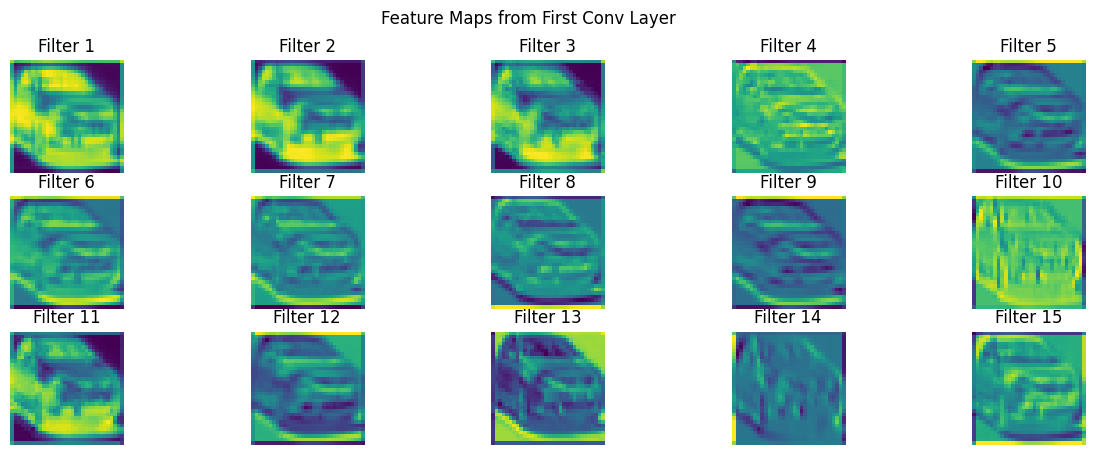

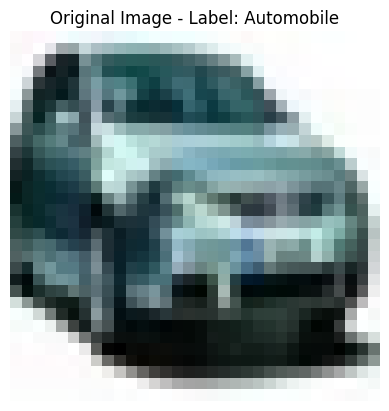

In [ ]:
image, label_idx = cifar10_sub_tr[235]
img_np = image.clone().permute(1,2,0).numpy()
image = image.unsqueeze(0) # Add additional dimension to match tr_nn input size
output = model(image) # Pass image thorugh layer


feature_maps = []

# Define a hook function to capture output from the conv1 layer
def hook_fn(module, input, output):
    feature_maps.append(output.detach())

# Register the hook on the first convolutional layer of the model
hook = model.conv1.register_forward_hook(hook_fn)

# Set model to evaluation mode
model.eval()

# Run a forward pass with the selected image (triggers the hook)
_ = model(image)

# Extract and process the stored feature map
act = feature_maps[0].squeeze(0)

# Plot the first 15 feature maps
fig, axes = plt.subplots(3, 5, figsize = (15,5))
axes = axes.flatten()
for i in range(15):
    axes[i].imshow(act[i].cpu().numpy(), cmap = 'viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i + 1}')

plt.suptitle("Feature Maps from First Conv Layer")
plt.show()

# Plot the original input image
plt.figure()
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image - Label: Automobile")
plt.show()

# III. Transfer Learning / Fine tuning


Suppose you have a slightly different classification task at hand: to correctly separate trucks from airplanes. 

We'll examine how we can use an already trained model to do this, instead of coding up a new neural network from scratch. 

You are required to implement two approaches -- the first simply updates the weights for the model you have trained in Question 9, while the second involves loading a larger pre-trained model (e.g. ResNet)

<span style="color:red">Warning!</span> Note that the second approach could be slow / time-consuming. If you are attempting it, please ensure that you budget ~20 mins to 1hour (worst case) for the code to complete running for this part. 

### Question 11: Planes and Trucks

Create a subset of the CIFAR 10 data, keeping only the airplane and truck classes. 


In [ ]:
# Create training subset with only plane and truck labels
sel_labels = [0,9]
targets = np.array(cifar10.targets)
idxs = np.where(np.isin(targets, sel_labels))[0]
plane_truck = torch.utils.data.Subset(cifar10, idxs)

#Split training subset into training and validation
total_len =len(plane_truck)
val_len = int(0.2 * total_len)
train_len = total_len - val_len
plane_truck_tr, plane_truck_val = torch.utils.data.random_split(
    cifar10_sub, [train_len, val_len],
    generator = torch.Generator().manual_seed(31))


# Create subset with only plane and truck labels for test set
targets = np.array(cifar10_val.targets)
idxs = np.where(np.isin(targets, sel_labels))[0]
plane_truck_test = torch.utils.data.Subset(cifar10_val, idxs)

### Question 12: Update Weights

First, use your model from Question 9 above -- and update the weights. To be precise:
- Save the model weights from Question 9.
- Then, create a new instance of the model from Question 9.
- Load the saved weights into the new model (Hint: the load_state_dict function is your friend here)
- Train this model for 10 epochs. 
- Report the accuracy, recall, precision and f1-score on the training and validation sets.
 

In [ ]:
plane_model = NewNet()

# Load previously saved weights from disk
plane_model.load_state_dict(torch.load("newnet_weights.pth"))

learning_rate = 1e-3
optimizer = torch.optim.Adam(plane_model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()

# Data loaders for training and validation (airplane vs. truck subset)
train_loader = DataLoader(plane_truck_tr, batch_size = 32, shuffle= True)
val_loader = DataLoader(plane_truck_val, batch_size = 32, shuffle= True)

training(plane_model, 10, optimizer, loss, train_loader)
validate(plane_model, val_loader)

Epoch 1: loss = 0.2322, time = 6.19s
Epoch 2: loss = 0.2283, time = 6.04s
Epoch 3: loss = 0.2225, time = 5.48s
Epoch 4: loss = 0.2246, time = 6.0s
Epoch 5: loss = 0.2194, time = 6.12s
Epoch 6: loss = 0.2148, time = 5.92s
Epoch 7: loss = 0.2080, time = 6.01s
Epoch 8: loss = 0.2072, time = 6.61s
Epoch 9: loss = 0.2057, time = 6.25s
Epoch 10: loss = 0.1962, time = 6.11s
Accuracy: 0.8750
Precision: 0.8164
Recall: 0.9767
F1 Score: 0.8894


(0.875, 0.8164094090461731, 0.9766764044761658, 0.8893805146217346)

### Question 13: Fine Tuning [Extra Credit]

Second, we'll load a pre-trained model (e.g. ResNet50, or VGG19). While these models haven't seen the exact images in this dataset, they have been trained on a large general corpus. Since these models have millions of weights, so we'll implement the following approach:
- Load the pretrained model (pick any from several [available models](https://pytorch.org/vision/stable/models.html))
- Freeze the weights for all the layers (in pytorch, you can do this using model_object.parameters())
- Replace the final fully connected layer, since you have a binary classification task. You can add additional fully connected layers if you wish, alongwith related activation functions etc.
- Finally, train this new model for 10 epochs.
- Report the accuracy, recall, precision and f1-score on the training and validation sets.
    

In [55]:
### YOUR CODE HERE

### Question 14: Conclusion [Extra Credit]

Compare model performance from Questions 12 and 13, and briefly summarize your observations. 